<a href="https://colab.research.google.com/github/rendalamili/ml-for-table-extraction/blob/main/Table_Detection_and_Structure_Recognition_Pipeline_for_PDF_Documents_Using_YOLO_and_Table_Transformer_with_JSON_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resources:

https://iamrajatroy.medium.com/document-intelligence-series-part-1-table-detection-with-yolo-1fa0a198fd7

https://huggingface.co/foduucom/table-detection-and-extraction

https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Using_Table_Transformer_for_table_detection_and_table_structure_recognition.ipynb

https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Inference_with_Table_Transformer_(TATR)_for_parsing_tables.ipynb

In [1]:
# Install Packages
!pip install ultralyticsplus==0.0.28 ultralytics==8.0.43 pdf2image matplotlib
!apt-get install -y poppler-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.6/299.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 10.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=f044968c8a5f51cae8fe689387a275187619b8f0afb969612afd2d8a7426f9d6
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from pdf2image import convert_from_path
from google.colab import files
from ultralyticsplus import YOLO, render_result
from transformers import DetrImageProcessor, TableTransformerForObjectDetection

Detection

In [3]:
# Load YOLO model for table detection
yolo_model = YOLO('keremberke/yolov8m-table-extraction')
yolo_model.overrides['conf'] = 0.25  # NMS confidence threshold
yolo_model.overrides['iou'] = 0.45  # NMS IoU threshold
yolo_model.overrides['agnostic_nms'] = False  # NMS class-agnostic
yolo_model.overrides['max_det'] = 1000  # Maximum detections per image

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

best.pt:   0%|          | 0.00/52.0M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:340: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


In [4]:
# Set display options for pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
# Define colors in the 0-255 range for bounding box visualization
COLORS = [(int(r * 255), int(g * 255), int(b * 255)) for r, g, b in
          [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098],
           [0.929, 0.694, 0.125], [0.494, 0.184, 0.556],
           [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]]

# Function to visualise the bounding boxes and labels on an image with table structure
def render_structure_on_image_with_labels(pil_img, scores, labels, boxes, color_map=COLORS):
    img_copy = pil_img.convert("RGB")
    draw = ImageDraw.Draw(img_copy)

    # Load default or Arial font for text rendering
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()

    # Draw bounding boxes with labels and scores on the image
    for score, label, (xmin, ymin, xmax, ymax), color in zip(scores.tolist(), labels.tolist(), boxes.tolist(), color_map * 100):
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=3)

        # Display label with score
        text = f"{model.config.id2label[label]}: {score:.2f}"
        text_bbox = draw.textbbox((xmin, ymin), text, font=font)
        draw.rectangle([xmin, ymin - text_bbox[3] + text_bbox[1], xmin + text_bbox[2] - text_bbox[0], ymin], fill="black")
        draw.text((xmin, max(0, ymin - (text_bbox[3] - text_bbox[1]))), text, fill="white", font=font)

    # Display the image with annotations
    print("Displaying table structure with enhanced bounding boxes and labels")
    display(img_copy)

In [6]:
# Upload a PDF file
uploaded = files.upload()
pdf_file = next(iter(uploaded.keys()))  # Get the PDF filename

Saving Table 1_ Simple 3x3 Table.pdf to Table 1_ Simple 3x3 Table.pdf


In [7]:
# Convert the PDF to images (use the first page)
pages = convert_from_path(pdf_file, dpi=300)
img = pages[0]  # Select the first page as an image

In [8]:
# Perform YOLO inference
yolo_results = yolo_model.predict(img)

Ultralytics YOLOv8.0.43 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs

0: 640x480 1 bordered, 1317.5ms
Speed: 1.6ms preprocess, 1317.5ms inference, 42.5ms postprocess per image at shape (1, 3, 640, 640)


Boxes:  tensor([[ 68.00000,  67.00000, 434.00000, 272.00000,   0.46238,   0.00000]])


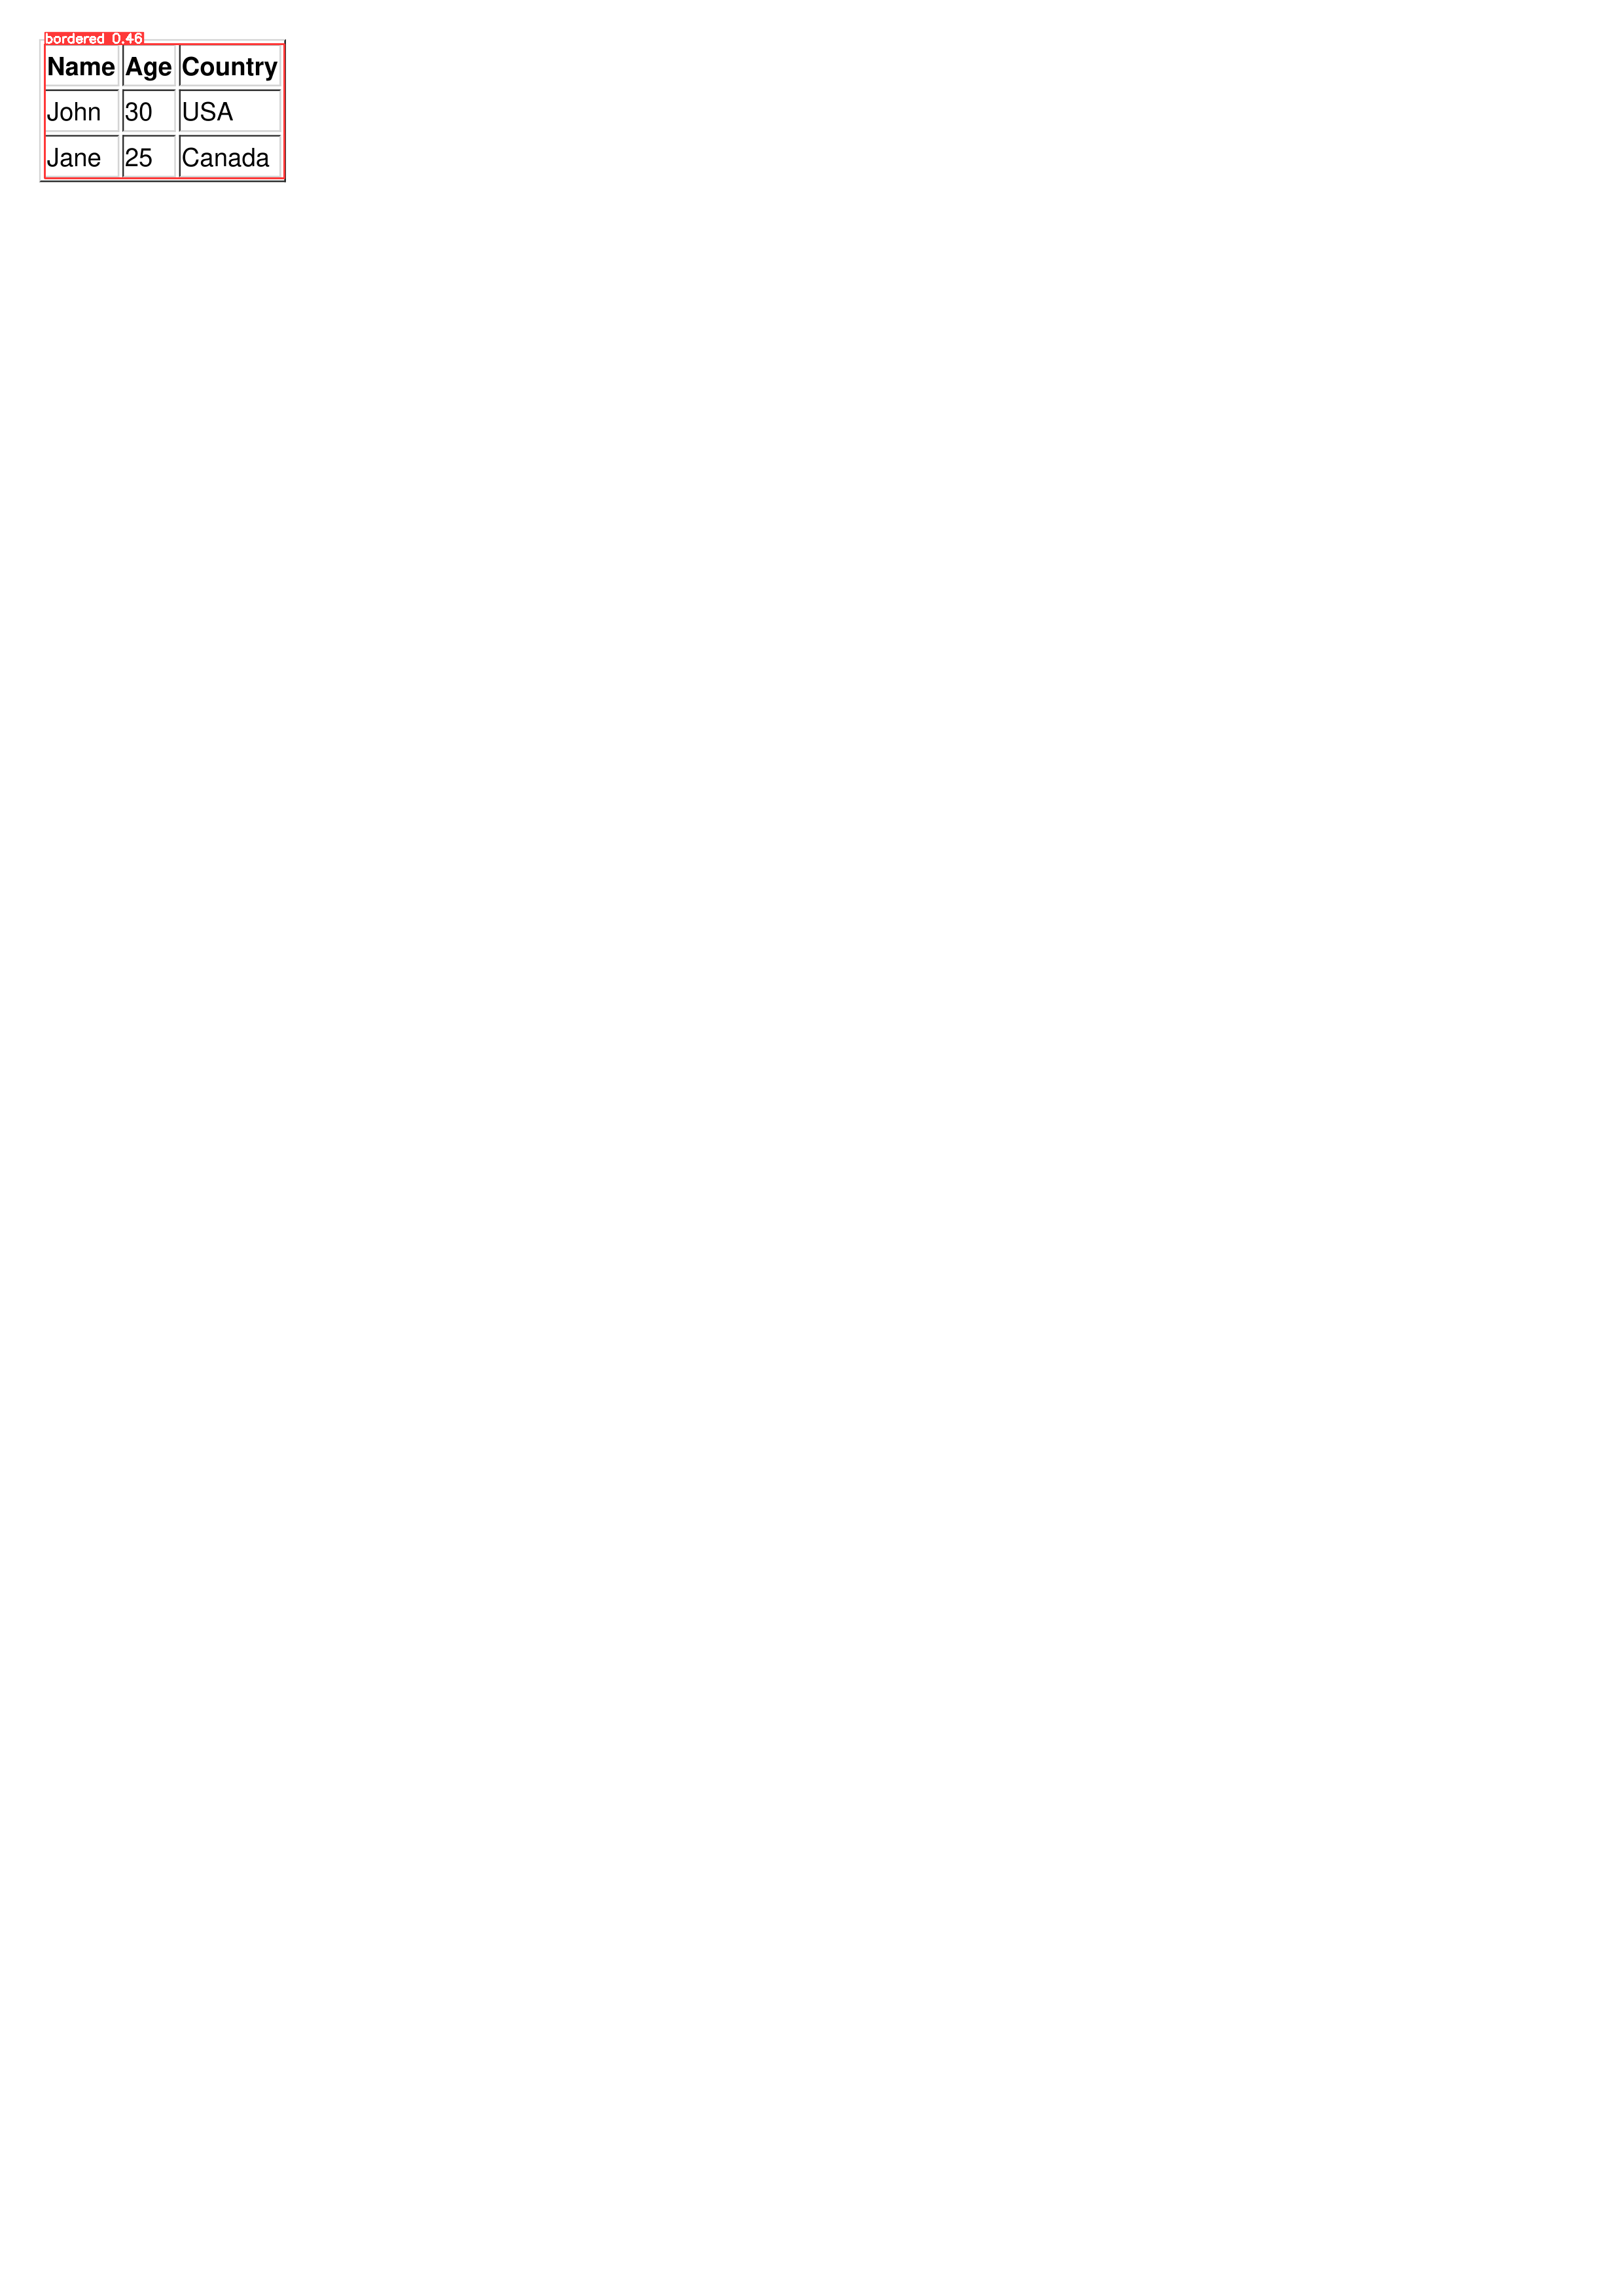

In [9]:
# observe results
print('Boxes: ', yolo_results[0].boxes)
render = render_result(model=yolo_model, image=img, result=yolo_results[0])
render

Cropping

Displaying cropped table 1


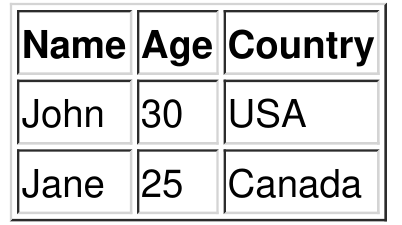

In [10]:
# Function to crop tables with dynamic padding based on box dimensions
def crop_table_with_dynamic_padding(image, box, padding_ratio=0.05):
    x_min, y_min, x_max, y_max = [int(coord) for coord in box.xyxy[0].tolist()]
    width, height = x_max - x_min, y_max - y_min

    # Calculate padding as a percentage of the detected table dimensions
    padding_x = int(width * padding_ratio)
    padding_y = int(height * padding_ratio)

    # Apply padding with boundary checks
    x_min, y_min = max(0, x_min - padding_x), max(0, y_min - padding_y)
    x_max, y_max = min(image.width, x_max + padding_x), min(image.height, y_max + padding_y)

    # Crop the image
    return image.crop((x_min, y_min, x_max, y_max))

# Crop detected tables based on dynamic padding
cropped_tables = []
for i, box in enumerate(yolo_results[0].boxes):
    cropped_table = crop_table_with_dynamic_padding(img, box)
    cropped_tables.append(cropped_table)
    print(f"Displaying cropped table {i + 1}")
    display(cropped_table)

Structure Recgonition

In [11]:
# Initialise the Table Transformer model for structure recognition
processor = DetrImageProcessor.from_pretrained("microsoft/table-transformer-structure-recognition")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Displaying table structure with enhanced bounding boxes and labels


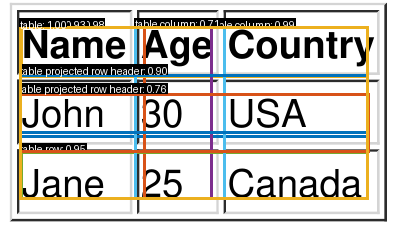

In [12]:
# Perform structure recognition on cropped table and render results
for i, cropped_table in enumerate(cropped_tables):
    encoding = processor(images=cropped_table, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encoding)

    # Post-process the output to get bounding boxes, labels, and scores
    target_sizes = [cropped_table.size[::-1]]
    results = processor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]

    # Render detected table structure on the image
    scores, labels, boxes = results["scores"], results["labels"], results["boxes"]
    render_structure_on_image_with_labels(cropped_table, scores, labels, boxes)

OCR

In [13]:
!pip install numpy
!pip install tqdm

In [14]:
# Function to get cell coordinates by row
def get_cell_coordinates_by_row(table_data):
    # Extract and sort rows and columns based on labels
    rows = sorted(
        [box for box, label in zip(table_data['boxes'], table_data['labels']) if label == model.config.label2id['table row']],
        key=lambda x: x[1]  # Sort by ymin
    )
    columns = sorted(
        [box for box, label in zip(table_data['boxes'], table_data['labels']) if label == model.config.label2id['table column']],
        key=lambda x: x[0]  # Sort by xmin
    )

    # Generate cell coordinates
    cell_coordinates = [
        {
            'row': row,
            'cells': [{'column': column, 'cell': (column[0], row[1], column[2], row[3])} for column in columns]
        }
        for row in rows
    ]

    # Sort cells within each row by X coordinate (xmin)
    for row_data in cell_coordinates:
        row_data['cells'].sort(key=lambda x: x['cell'][0])

    return cell_coordinates

# Get cell coordinates
cell_coordinates = get_cell_coordinates_by_row({'boxes': boxes, 'labels': labels})

In [15]:
!pip install pytesseract
!apt-get install -y tesseract-ocr
import pytesseract
from PIL import Image
from tqdm.auto import tqdm #Progress Bar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,054 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123659 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [16]:
# Apply OCR using Tesseract row by row on cell coordinates
def apply_ocr_tesseract(cell_coordinates, cropped_table_image):
    data = {}
    max_num_columns = 0

    # Apply OCR for each row of cell coordinates
    for idx, row_data in enumerate(tqdm(cell_coordinates, desc="Applying OCR with Tesseract")):
        row_text = []
        for cell in row_data['cells']:
            x_min, y_min, x_max, y_max = [int(coord) for coord in cell['cell']]
            cell_image = cropped_table_image.crop((x_min, y_min, x_max, y_max))
            cell_image = cell_image.convert("L")  # Convert to grayscale if needed

            # Apply OCR with Tesseract
            text = pytesseract.image_to_string(cell_image, config='--psm 6')
            row_text.append(text.strip())

        max_num_columns = max(max_num_columns, len(row_text))
        data[idx] = row_text

    # Pad rows to ensure uniform number of columns
    for row, row_data in data.items():
        row_data.extend([""] * (max_num_columns - len(row_data)))
        data[row] = row_data

    return data

# Apply OCR and extract text
data_tesseract = apply_ocr_tesseract(cell_coordinates, cropped_table)

# Print OCR results row by row
print("Results using Tesseract OCR:")
for row, row_data in data_tesseract.items():
    print(row_data)

Applying OCR with Tesseract:   0%|          | 0/3 [00:00<?, ?it/s]

Results using Tesseract OCR:
['Name |', '|Age', '|Country']
['John |', '30', 'USA']
['Jane |', 'lo5', 'Canada']


JSON Extraction

In [30]:
import json
import torch

# Clean function to remove extra spaces and characters
def clean_data(value):
    return value.strip().replace('|', '').strip()

# Extract headers from the first row
headers = [clean_data(header) for header in data_tesseract[0]]

# Get list of keys (row indices) exclude the header row (key 0)
row_indices = list(data_tesseract.keys())[1:]

# Create table content
table_content = [
    {headers[col_idx]: clean_data(cell) for col_idx, cell in enumerate(data_tesseract[row_idx])}
    for row_idx in row_indices
]

# Store extracted table data
table_json = {
    "table_data": table_content
}

# Save extracted table data as a JSON file
with open('extracted_table_data.json', 'w') as json_file:
    json.dump(table_json, json_file, indent=4)

# Print JSON table data
print(json.dumps(table_json, indent=4))

{
    "table_data": [
        {
            "Name": "John",
            "Age": "30",
            "Country": "USA"
        },
        {
            "Name": "Jane",
            "Age": "lo5",
            "Country": "Canada"
        }
    ]
}
